In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import minmax_normalize,symmetric_minmax_normalize,sum_channels
from source.labels import IMAGENET_LABELS

/Midgard/home/amirme/an_explanation_model


2023-09-11 09:53:22.947285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 09:53:29.776001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_metadata = load_experiment_metadata(glob_path="experiment_1/*")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(["stream_name","stream_statistic","alpha_mask_value"]).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_index', 'projection_distribution', 'baseline_mask_type',
       'baseline_mask_value', 'write_demo', 'architecture', 'max_batches',
       'min_change', 'seed', 'batch_size', 'num_classes', 'input_shape',
       'image_index', 'monitored_statistic', 'monitored_stream', 'dataset',
       'label', 'image_path', 'time_to_compute', 'batch_index',
       'monitored_statistic_change', 'data_path', 'stream_name',
       'stream_statistic', 'csv_file_path'],
      dtype='object')
(840, 26)


In [3]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))

stream_name            stream_statistic  alpha_mask_value
alpha_mask             none              0.1                 6
results_at_projection  meanx2            0.7                 6
                                         0.1                 6
                                         0.2                 6
                                         0.3                 6
                                                            ..
log_probs              meanx             0.1                 6
image                  none              1.0                 6
                                         0.9                 6
                                         0.8                 6
vanilla_grad_mask      none              1.0                 6
Name: count, Length: 140, dtype: int64
140


In [62]:
image_indices=project_metadata["image_index"].unique()
image_indices

array([ 3, 11,  5, 13,  7,  9])

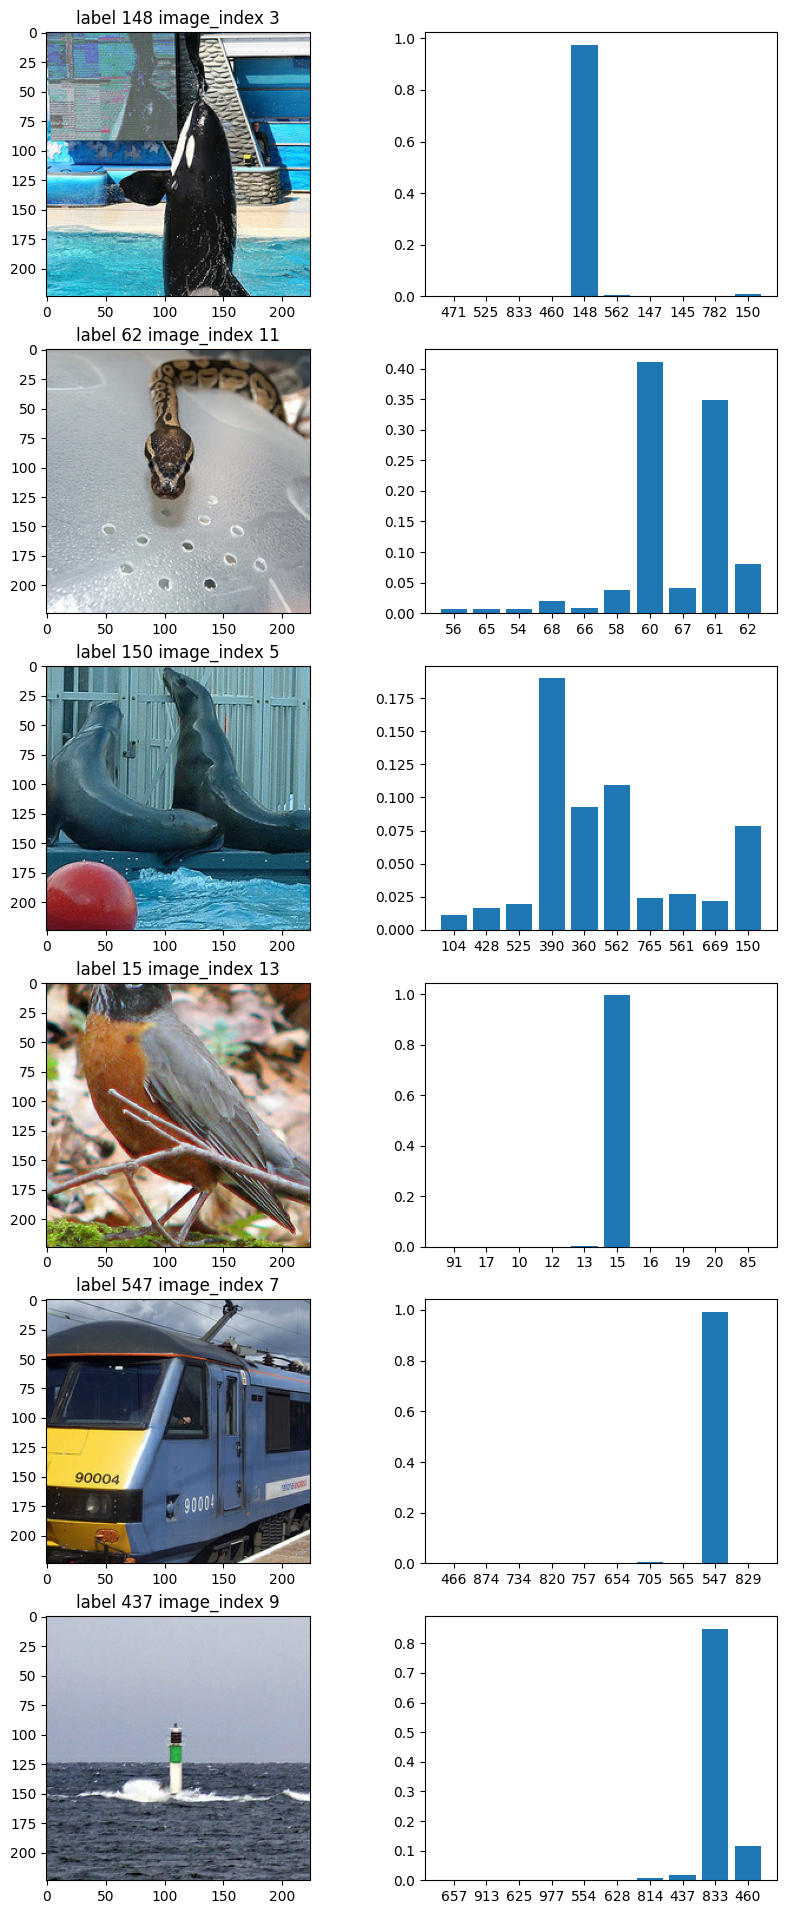

In [120]:
def plot_row(row):
    i = int(row["index"])
    axes[i,0].imshow(row["image"])
    x = np.arange(len(row["top_k"]))
    axes[i,1].bar(x,row["probs"],tick_label=row["top_k"])
    title = f"label {row['label']} image_index {row['image_index']}"
    axes[i,0].set_title(title)

temp_data = project_metadata.set_index("image_index",append=True)

raw_images = temp_data.loc[("image","none",0.1),"data_path"].apply(np.load)
raw_images.name = "image"
label = temp_data.loc[("log_probs","none",0.1),"label"]
log_probs = temp_data.loc[("log_probs","none",0.1),"data_path"].apply(np.load)

log_probs.name = "log_probs"
get_top_k = 10
top_k = log_probs.apply(lambda x: np.argpartition(x, -get_top_k)[-get_top_k:])

top_k.name = "top_k"
log_probs = pd.concat([log_probs,top_k],axis=1)

probs = log_probs.apply(lambda x: np.exp(x["log_probs"][x["top_k"]]),axis=1)
probs.name = "probs"

image_index = pd.Series(index=raw_images.index,
                  data=raw_images.index,
                  name="image_index")
index = pd.Series(index=raw_images.index,
                  data=range(raw_images.shape[0]),
                  name="index")

temp_data = pd.concat([index,image_index,raw_images,probs,top_k,label],axis=1)

nrows = 6
ncols = 2
fig,axes = plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*4))
temp_data.apply(plot_row,axis=1);

In [111]:
temp_metadata = project_metadata.set_index("image_index", append=True).sort_index()
temp_metadata = temp_metadata.loc[("log_probs"), :]
values = temp_metadata.loc[:, "data_path"].apply(lambda path: np.load(path))

meanx = values.loc["meanx"]
meanx2 = values.loc["meanx2"]

meanx.name = "values"
stdx = (meanx2 - meanx**2).apply(lambda x: np.sqrt(x))
stdx.name = "values"
get_top_k=3
pred_ids = meanx.apply(lambda x: np.argpartition(x, -get_top_k)[-get_top_k:])
pred_ids.name = "pred_ids"
pred_ids = pred_ids.to_frame()
alphas = pred_ids.index.get_level_values("alpha_mask_value")
pred_ids = pred_ids.explode("pred_ids")
pred_ids = pred_ids.groupby("image_index")["pred_ids"].unique().to_frame()
pred_ids = pred_ids.explode("pred_ids")
pred_ids = pd.concat(
    {alpha: pred_ids for alpha in alphas}, names=["alpha_mask_value"], axis=0
)

temp_df = pred_ids.apply(lambda x: meanx.loc[x.name][x["pred_ids"]], axis=1)
temp_df.name = "meanx"
pred_ids = pd.concat([pred_ids, temp_df], axis=1)

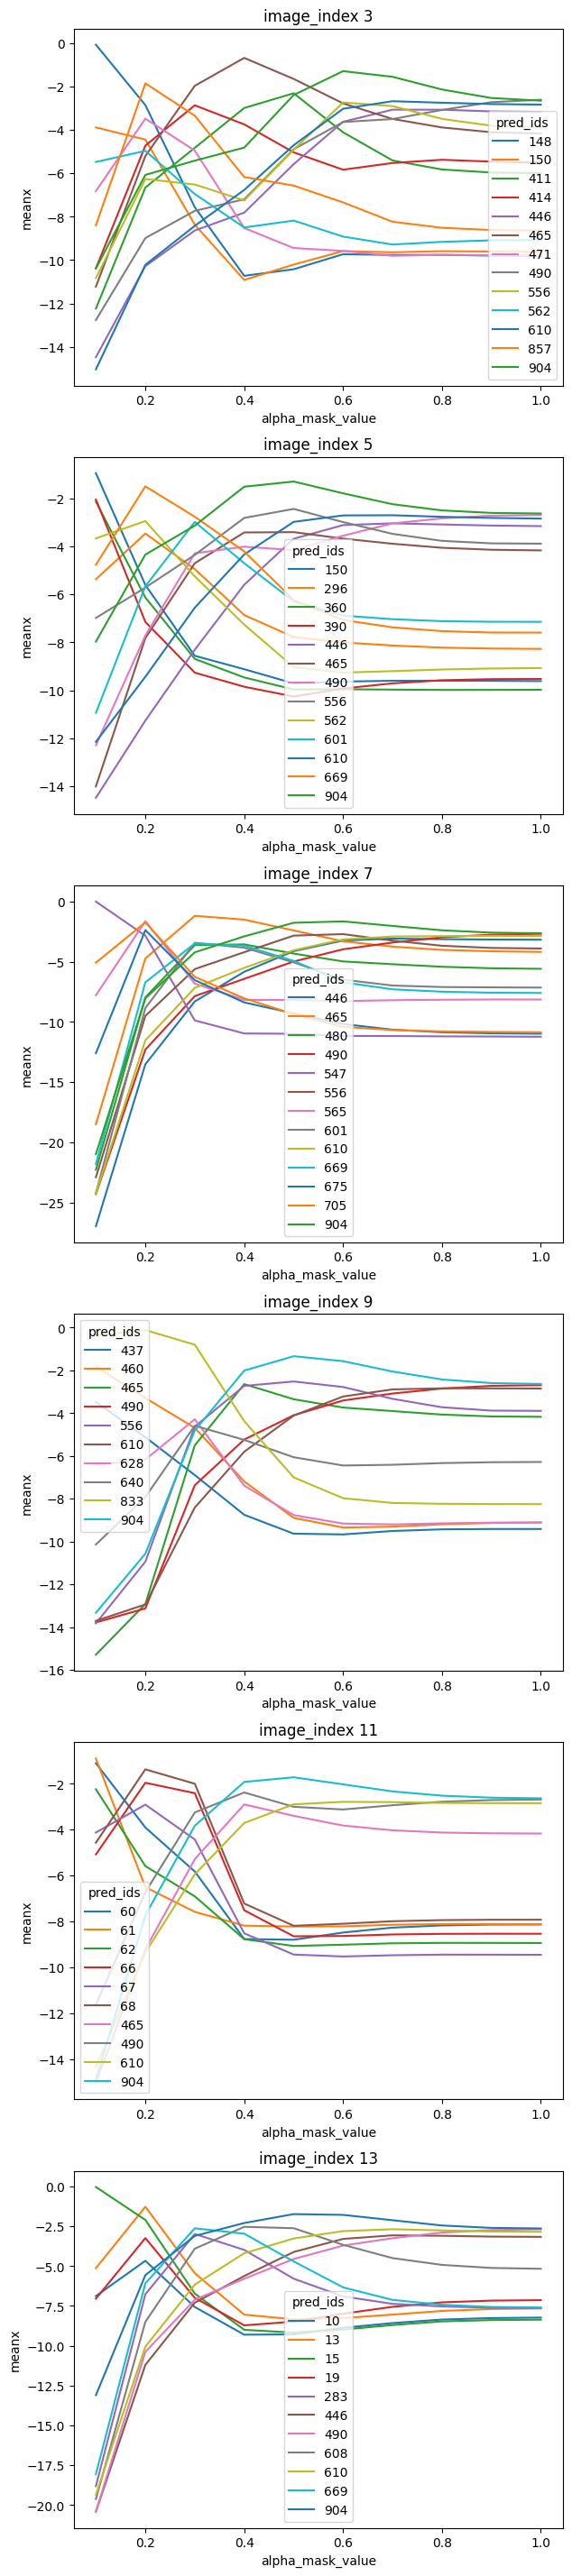

In [112]:
groups = pred_ids.reset_index().groupby("image_index")
nrows= len(image_indices)
fig,axes = plt.subplots(nrows,1,figsize=(7,6*nrows))
for i,(name, group) in enumerate(groups):
    sns.lineplot(
        ax = axes[i],
        x="alpha_mask_value",
        y="meanx",
        hue="pred_ids",
        data=group,
        palette="tab10",
    )
    axes[i].set_title(f"image_index {name}")